# Лабораторная работа № 5
| Автор                   | Группа   | Вариант |
| ----------------------- | -------- | ------- |
| Волков Матвей Андреевич | М8О-407б | 15      |

## Тема
Сети с обратными связями.

## Цель работы
исследование свойств сетей Хопфилда и Элмана, алгоритмов обуче-
ния, а также применение сетей в задачах распознавания статических и динамических
образов.

## Основные этапы работы
1. Использовать сеть Элмана для распознавания динамических образов. Прове-
рить качество распознавания.

2. Использовать сеть Хопфилда для распознавания статических образов. Прове-
рить качество распознавания.


## Данные 
### Динамический образ

$$g(k) = cos(-2k^2 + 7k), k \in [0.92,3.25]. \text{Длительность} p_1(k): [0,4,2]$$

### Статический образ
Цифры: [2,4,9]

## Исходный код 
### Part 1 (Динамический образ)

In [1]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

In [46]:

def plot_history(h, *metrics):
    "function for showing model history on plot with metrics"
    for metric in metrics:
        print(f"{metric}: {h[metric][-1]:.4f}")
    figure = make_subplots(rows=1, cols=len(metrics), subplot_titles=metrics)
    for i, metric in enumerate(metrics, 1):
        ax = np.arange(0, len(h[metric]), 1)
        figure.add_trace(
            go.Scatter(x=ax, y=h[metric], name=metric), col=i, row=1
        )
    figure.update_layout(title_text="Метрики")
    figure.show()

#### Сеть Эльмана

In [3]:
class ElmanLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(ElmanLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.w1 = nn.Parameter(torch.randn(in_features, out_features))
        self.w2 = nn.Parameter(torch.randn(out_features, out_features))
        self.b = nn.Parameter(torch.randn(out_features))
        self.prev = torch.zeros(out_features)
        
    def clear_memory(self):
        self.prev = torch.zeros(self.out_features)
        
    def forward(self, input):
        out = input @ self.w1 + self.b + self.prev @ self.w2
        out = torch.tanh(out)
        self.prev = out.clone().detach()
        return out

In [35]:
def signal(p1, p2, r1, r2, r3, a2, b2, h):
    t1 = np.arange(0, 1, h)
    t2 = np.arange(a2, b2, h)
    
    x1 = p1(t1)
    x2 = p2(t2)
    target1 = np.full(x1.shape, -1)
    target2 = np.full(x2.shape, 1)
    
    x = np.concatenate((np.tile(x1, r1), x2, np.tile(x1, r2), x2, np.tile(x1, r3), x2))
    target = np.concatenate((np.tile(target1, r1), target2, np.tile(target1, r2), target2, np.tile(target1, r3), target2))

    return [i for i in range(len(x))], x, target

def gen_dataset(data, target, window):
    return TensorDataset(
        torch.tensor(np.array([data[i:i+window] for i in range(len(data) - window + 1)]), dtype=torch.float32),
        torch.tensor(np.array([target[i:i+window] for i in range(len(target) - window + 1)]), dtype=torch.float32))

In [36]:
r1, r2, r3 = 0, 4, 2
a2, b2 = 0.92, 3.25
p1 = lambda k: sin(4 * pi * k)
p2 = lambda k: cos(-2*k**2 + 7*k)

In [37]:
tick, data, target = signal(p1, p2, r1, r2, r3, a2, b2, 0.01)

По условию мне дан для обучения данная картина

In [40]:
fig = go.Figure(go.Scatter(x=tick, y=data, name="signal"))
fig.add_trace(go.Scatter(x=tick, y=target, name="target"))
fig.show()

In [41]:
window = 8
hidden_layer = 16

In [42]:
dataset = gen_dataset(data, target, window)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [43]:
elman = nn.Sequential(
    ElmanLayer(window, hidden_layer),
    nn.Linear(hidden_layer, window)
)

Блок обучения

In [55]:
epochs = 210
optim = torch.optim.Adam(elman.parameters(), lr=1e-4)
crit = nn.MSELoss()
history = defaultdict(list)
elman.train()
for epoch in tqdm(range(epochs), desc='Epochs', ncols=70):
    losses = []
    epoch_correct = 0
    epoch_all = 0
    elman[0].clear_memory()
    for x_batch, y_batch in dataloader:
        out = elman(x_batch)
        pred = (out > 0).type(torch.long) * 2 - 1
        loss = crit(out, y_batch)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        epoch_correct += (pred == y_batch).sum().item()
        epoch_all += len(x_batch) * window
    
    history['accuracy'].append(epoch_correct / epoch_all)
    history['loss'].append(np.mean(losses))

Epochs: 100%|███████████████████████| 300/300 [04:17<00:00,  1.16it/s]


Обучающие метрики

In [56]:
plot_history(history, 'loss', 'accuracy')

loss: 0.0144
accuracy: 0.9959


In [57]:
elman.eval()
pred = []
for x, _ in dataset:
    pred.append(elman(x).detach().numpy().item(0))
pred.extend(elman(dataset[-1][0]).detach().numpy()[1:])
pred = np.array(pred)
pred = (pred > 0) * 2 - 1

После обучения получилось такая картина

In [61]:
fig = go.Figure(go.Scatter(x=tick[window:], y=data[window:], name="signal"))
fig.add_trace(go.Scatter(x=tick[window:], y=pred, name="func_type"))
fig.show()

Видно, что буквально на окно, которое я задал в своей программе ответ отстает. Это связано с тем, что сеть просто не успевает понять функцию. Ей для понимание нужно примерно пространство окна, которое было задано для обучения

### Part 2 (Статический образ)

#### Сеть Хопфилда

In [59]:
def load_image(path, width=320, height=240):
    image = Image.open(path)
    image = image.convert('RGB')  # удалить альфа канал, иногда он может присутствовать!
    image = image.resize((width, height), Image.ANTIALIAS)
    image = np.asarray(image, dtype=np.float32)
    image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.float32)  # получить float32 вместо double
    image = (image - 127.5) / 127.5  # нормализовать [-1..1]
    return image.flatten()

In [62]:
class HopfieldLayer(nn.Module):
    def __init__(self, in_features):
        super(HopfieldLayer, self).__init__()
        self.w = nn.Parameter(torch.zeros(in_features, in_features))
        self.b = nn.Parameter(torch.zeros(in_features))
        self.prev = torch.zeros(in_features)
        
    def set_initial_value(self, value):
        self.prev = value.detach().clone()
        
    def forward(self, input=0):
        out = torch.matmul(self.prev, self.w)
        out = torch.add(out, self.b)
        out = torch.clamp(out, min=-1, max=1)
        self.prev = out.detach().clone()
        return out

In [63]:
width = 10
height = 12

Загрузим цифры, нарисованные мной

In [67]:
def load_images():
    return [
        load_image('img/two.png', width, height),
        load_image('img/four.png', width, height),
        load_image('img/nine.png', width, height),
    ]

In [68]:
images = load_images()
dataloader = DataLoader(images, batch_size=1, shuffle=True)

C:\Users\matve\AppData\Local\Temp\ipykernel_11340\2352364065.py:4: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.



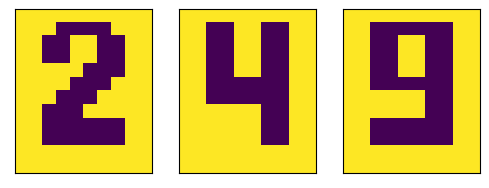

In [69]:
fig = plt.figure(figsize=(len(images) * 2, 4))
for i, img in enumerate(images):
    ax = fig.add_subplot(1, len(images), i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img.reshape(height, width))
plt.show()

In [81]:
hopfield = HopfieldLayer(width * height)

Я заметил, что обучение проходило очень плохо и распознавание цифр было плохое. Проблему решило большое количество эпох обучения. Такое обучение свлось почти к нулевому loss. 

In [82]:
epochs = 10000
optim = torch.optim.Adam(hopfield.parameters(), lr=1e-5)
crit = nn.MSELoss()
history = defaultdict(list)
hopfield.train()

for epoch in tqdm(range(epochs), desc='Epochs', ncols=70):
    for img in dataloader:
        losses = []
        hopfield.set_initial_value(img)
        out = hopfield()
        loss = crit(out, img)

        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())

        history['loss'].append(np.mean(losses))

Epochs: 100%|██████████████████| 10000/10000 [00:16<00:00, 610.87it/s]


In [83]:
plot_history(history, 'loss')

loss: 0.0000


Вот результат

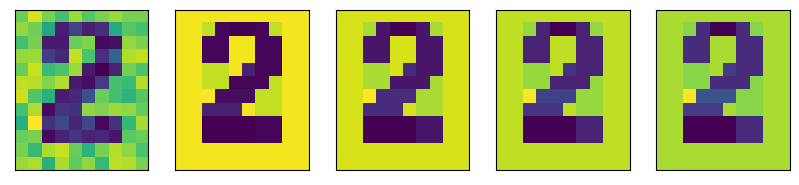

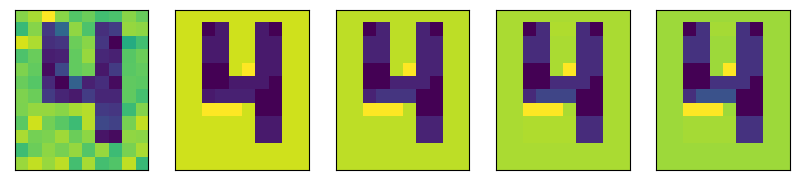

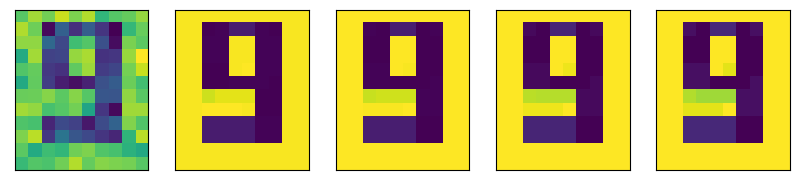

In [84]:
for img in images:
    out = torch.clamp(torch.tensor(img) + torch.randn(img.shape) / 4, -2, 2) / 2

    hopfield.eval()
    hopfield.set_initial_value(out)
    steps = 5
    fig = plt.figure(figsize=(steps * 2, 4))
    for i in range(steps):
        ax = fig.add_subplot(1, steps, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(out.detach().numpy().reshape(height, width))
        out = hopfield()
    plt.show()

### Вывод
В ходе выполнения лабораторной работы я познакомился рекуррентными сетями. За счет использования информации о предыдущем состоянии, рекуррентные сети могут распознавать сложные динамические образы силами одного линейного слоя или использоваться в качестве автоассоциативной памяти. Также заметно, что для таких сетей нужно большое количество эпох обучения, чтобы хорошо себя проявить